# Importing Necessary Modules

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense,  Flatten

# Importing Datasets from Kaggle

In [ ]:
!kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 97% 84.0M/86.8M [00:00<00:00, 174MB/s]
100% 86.8M/86.8M [00:00<00:00, 146MB/s]


In [ ]:
!unzip brain-tumor-classification-mri.zip

# Datasets Visualization



glioma_tumor


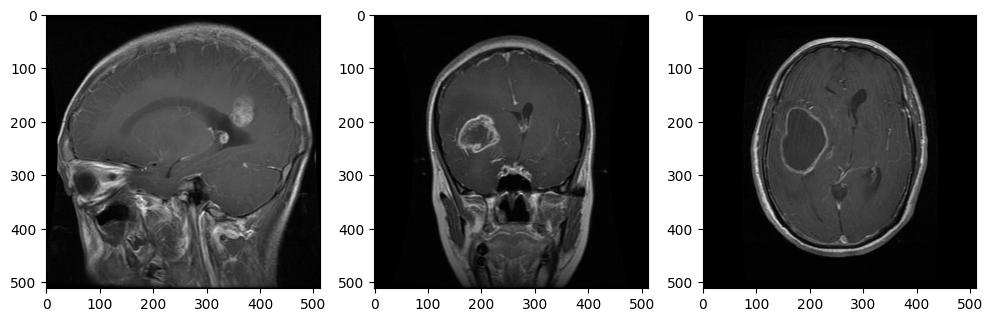

meningioma_tumor


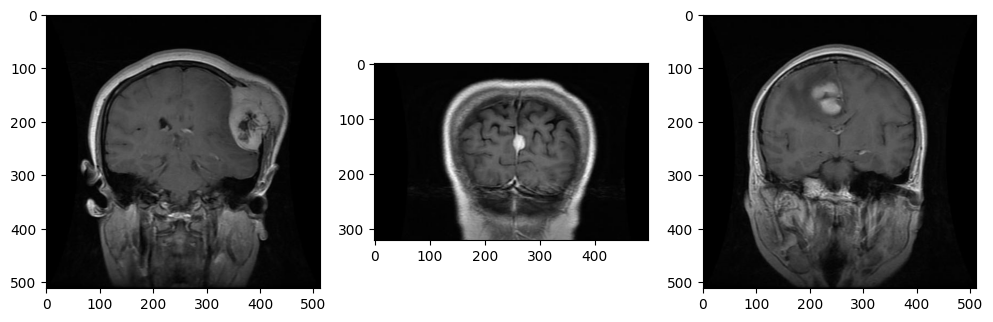

no_tumor


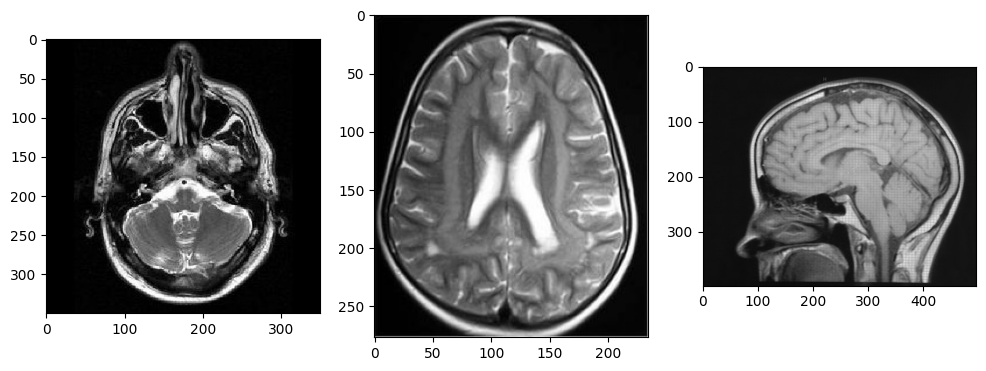

pituitary_tumor


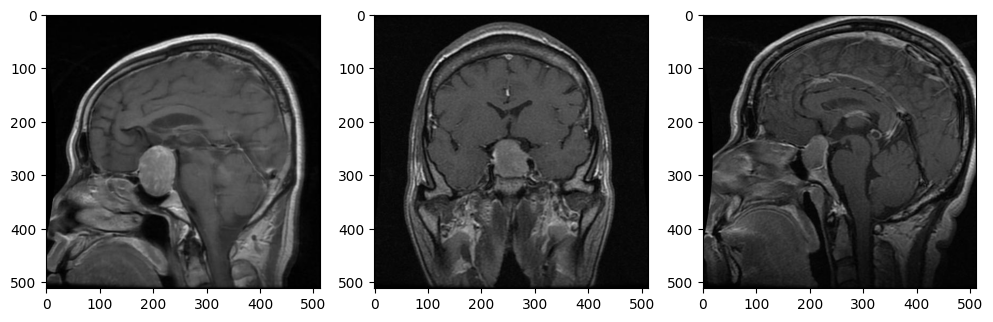

In [ ]:
for category in ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]:
    path = os.path.join("/content/Training", category)
    images = os.listdir(path)
    plt.figure(figsize=(12, 12))
    print(category)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        img = plt.imread(os.path.join(path, images[i]))
        plt.imshow(img)
    plt.show()


# Histogram Equalization with CLAHE

In [ ]:
os.makedirs("/content/Training_output", exist_ok=True)

for label in os.listdir("/content/Training"):
    label_path = os.path.join("/content/Training", label)

    if os.path.isdir(label_path):
        output_label_path = os.path.join("/content/Training_output", label)
        os.makedirs(output_label_path, exist_ok=True)

        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)

            img = cv2.imread(image_path)
            if img is not None:
                clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4, 4))
                channels = cv2.split(img)
                clahe_channels = [clahe.apply(channel) for channel in channels]
                clahe_rgb = cv2.merge(clahe_channels)
                cv2.imwrite(os.path.join(output_label_path, image_name), clahe_rgb)
print("Training data processing with CLAHE completed.")


os.makedirs("/content/Test_output", exist_ok=True)

for label in os.listdir("/content/Testing"):
    label_path = os.path.join("/content/Testing", label)

    if os.path.isdir(label_path):
        output_label_path = os.path.join("/content/Test_output", label)
        os.makedirs(output_label_path, exist_ok=True)

        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)

            img = cv2.imread(image_path)
            if img is not None:
                clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4, 4))
                channels = cv2.split(img)
                clahe_channels = [clahe.apply(channel) for channel in channels]
                clahe_rgb = cv2.merge(clahe_channels)
                cv2.imwrite(os.path.join(output_label_path, image_name), clahe_rgb)
print("Testing data processing with CLAHE completed.")

Training data processing with CLAHE completed.
Testing data processing with CLAHE completed.


# Datasets Visualization after Histogram Equalization

glioma_tumor


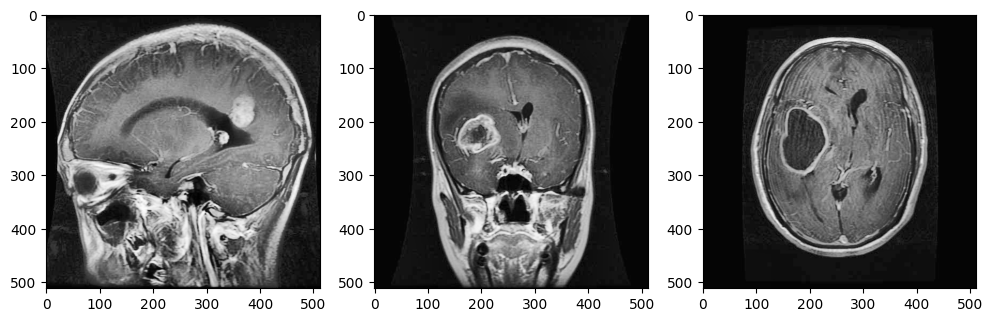

meningioma_tumor


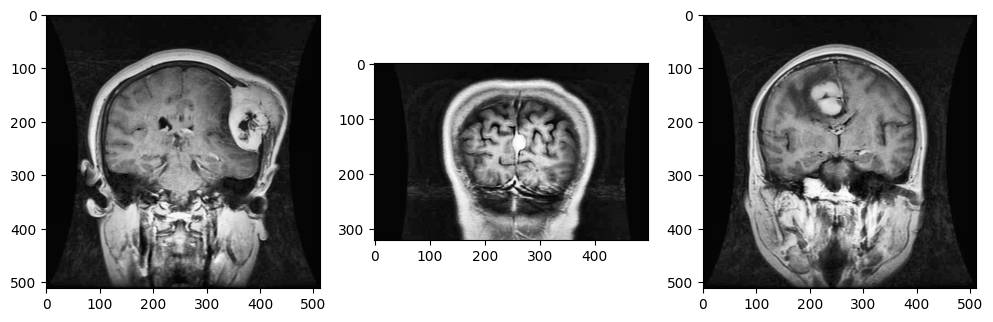

no_tumor


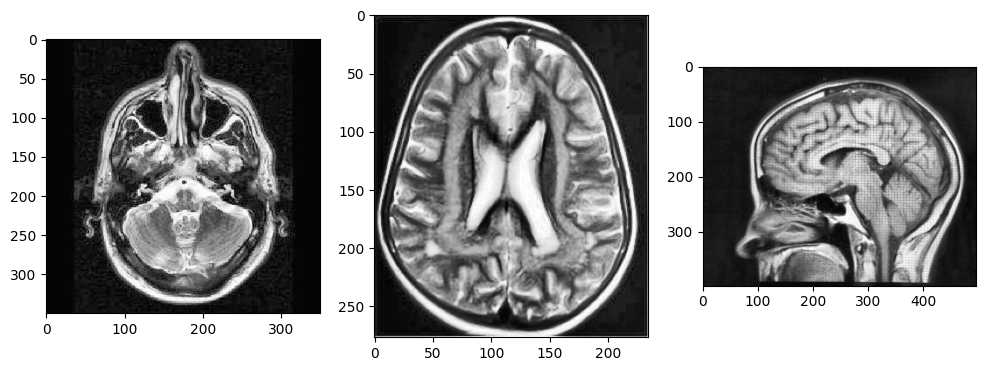

pituitary_tumor


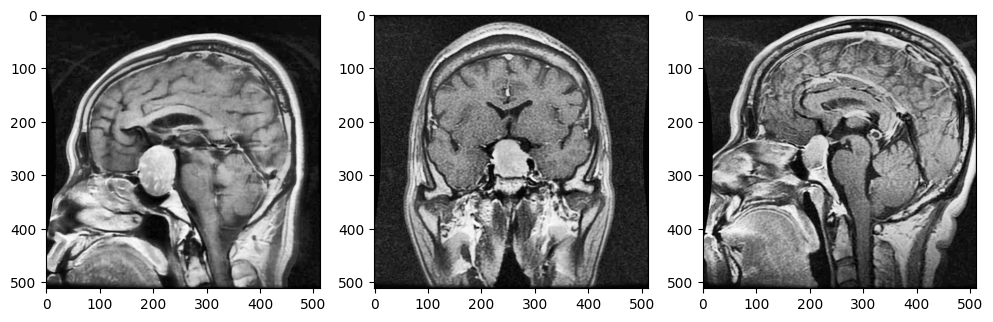

In [ ]:
for category in ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]:
  path = os.path.join("/content/Training_output",category)
  images = os.listdir(path)
  plt.figure(figsize=(12,12))
  print(category)
  for i in range(3) :
    plt.subplot(1,3,i+1)
    img = plt.imread(os.path.join(path,images[i]))
    plt.imshow(img)
  plt.show()

# Loading and Preprocessing Datasets for Transfer Learning

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/Training_output',
    image_size=(128, 128),
    batch_size=8,
    labels="inferred",
    label_mode="int"
)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = dataset.shuffle(buffer_size=1000)
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Training_output',
    image_size=(128, 128),
    batch_size=8,
    validation_split=0.4,
    subset="validation",
    seed=123,
    labels="inferred",
    label_mode="int"
)

val_ds = val_ds.shuffle(buffer_size=1000)
val_ds = val_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)


Found 2870 files belonging to 4 classes.
Found 2870 files belonging to 4 classes.
Using 1148 files for validation.


# Training Datasets using ResNet Transfer Model

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.keras.backend.clear_session()

In [ ]:
base_model_resnet =  ResNet50(weights="imagenet",include_top=False,input_shape=(128,128,3))
for layer in base_model_resnet.layers :
  layer.trainable = False

x = base_model_resnet.output
x = Flatten()(x)
prediction_resnet = Dense(4 , activation="softmax")(x)
model_resnet = Model(inputs=base_model_resnet.input , outputs=prediction_resnet)
model_resnet.compile(loss="sparse_categorical_crossentropy" , optimizer="adam" , metrics=["accuracy"])

In [ ]:
history_resnet = model_resnet.fit(train_ds, epochs=10 , validation_data=val_ds)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 255s 688ms/step - accuracy: 0.6786 - loss: 4.5310 - val_accuracy: 0.8807 - val_loss: 1.2859
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 273s 721ms/step - accuracy: 0.8705 - loss: 1.9470 - val_accuracy: 0.9469 - val_loss: 0.4272
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 248s 683ms/step - accuracy: 0.9303 - loss: 0.8547 - val_accuracy: 0.9399 - val_loss: 0.7187
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 262s 684ms/step - accuracy: 0.9202 - loss: 1.1564 - val_accuracy: 0.9068 - val_loss: 1.5463
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 261s 681ms/step - accuracy: 0.9468 - loss: 0.6433 - val_accuracy: 0.9843 - val_loss: 0.1369
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 276s 719ms/step - accuracy: 0.9757 - loss: 0.2180 - val_accuracy: 0.9564 - val_loss: 0.5810
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 249s 681ms/step - accuracy: 0.9752 - loss: 0.2583 - val_accuracy: 0.9556 - val_loss: 0.5473
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 277s 723ms/step - accuracy: 0.9718 -

In [ ]:
model_resnet.save("ResNet_model_combine.keras")

# Model Evaluation in ResNet Model

In [ ]:
print("Accuracy : ", history_resnet.history["accuracy"][-1])
print("Validation Accuracy : ", history_resnet.history["val_accuracy"][-1])
print("Loss : ", history_resnet.history["loss"][-1])
print("Validation Loss : ", history_resnet.history["val_loss"][-1])

Accuracy :  0.9836236834526062
Validation Accuracy :  0.9799651503562927
Loss :  0.17750874161720276
Validation Loss :  0.24349649250507355


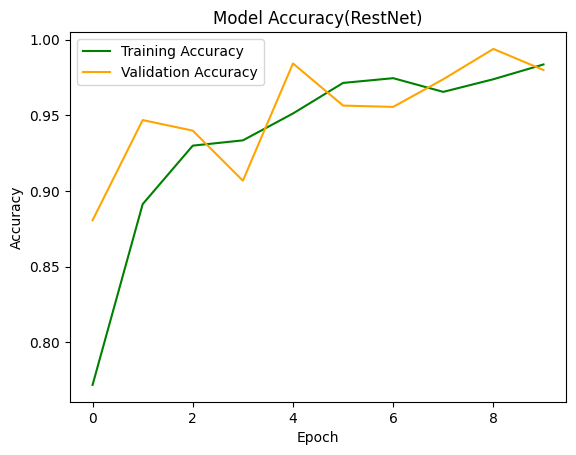

In [ ]:
plt.plot(history_resnet.history["accuracy"], color="green", label="Training Accuracy")
plt.plot(history_resnet.history["val_accuracy"], color="orange", label="Validation Accuracy")
plt.title("Model Accuracy(RestNet)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

# Data Prediction in ResNet Model

In [ ]:
image_to_test1 = cv2.imread("/content/Test_output/glioma_tumor/image(76).jpg")
image_to_test1 = cv2.resize(image_to_test1, (128, 128))
image_to_test1 = image_to_test1.reshape(1, 128, 128, 3)

image_to_test2 = cv2.imread("/content/Test_output/pituitary_tumor/image(88).jpg")
image_to_test2 = cv2.resize(image_to_test2, (128, 128))
image_to_test2 = image_to_test2.reshape(1, 128, 128, 3)

categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
pred1 = np.argmax(model_resnet.predict(image_to_test1))
pred2 = np.argmax(model_resnet.predict(image_to_test2))

print("Prediction 1: \nActual data : glioma_tumor \nPredicted data :", categories[pred1])
if categories[pred1] == "glioma_tumor":
    print("Correct prediction!\n\n")

print("Prediction 2: \nActual data : pituitary_tumor \nPredicted data :", categories[pred2])
if categories[pred2] == "pituitary_tumor":
    print("Correct prediction!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Prediction 1: 
Actual data : glioma_tumor 
Predicted data : glioma_tumor
Correct prediction!


Prediction 2: 
Actual data : pituitary_tumor 
Predicted data : meningioma_tumor


# Training Datasets using VGG16 Transfer Model

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.keras.backend.clear_session()

In [ ]:
base_model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
for layer in base_model_vgg16.layers:
    layer.trainable = False

x = base_model_vgg16.output
x = Flatten()(x)
prediction_vgg16 = Dense(4, activation="softmax")(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=prediction_vgg16)
model_vgg16.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history_vgg16 = model_vgg16.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - accuracy: 0.7061 - loss: 5.6522 - val_accuracy: 0.8676 - val_loss: 2.1633
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.8759 - loss: 1.9224 - val_accuracy: 0.9347 - val_loss: 0.8499
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.9222 - loss: 1.1226 - val_accuracy: 0.9634 - val_loss: 0.4850
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - accuracy: 0.9373 - loss: 0.7737 - val_accuracy: 0.9721 - val_loss: 0.4329
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.9529 - loss: 0.6196 - val_accuracy: 0.9434 - val_loss: 0.8013
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.9503 - loss: 0.9352 - val_accuracy: 0.9582 - val_loss: 0.5613
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - accuracy: 0.9659 - loss: 0.4602 - val_accuracy: 0.9782 - val_loss: 0.2595
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.9681 - loss: 0.5651 - val_accu

In [ ]:
model_vgg16.save("VGG16_model_combine.keras")

# Model Evaluation in VGG16 Model

In [ ]:
print("Accuracy : ", history_vgg16.history["accuracy"][-1])
print("Validation Accuracy : ", history_vgg16.history["val_accuracy"][-1])
print("Loss : ", history_vgg16.history["loss"][-1])
print("Validation Loss : ", history_vgg16.history["val_loss"][-1])

Accuracy :  0.9808362126350403
Validation Accuracy :  0.9834494590759277
Loss :  0.3209471106529236
Validation Loss :  0.2430032342672348


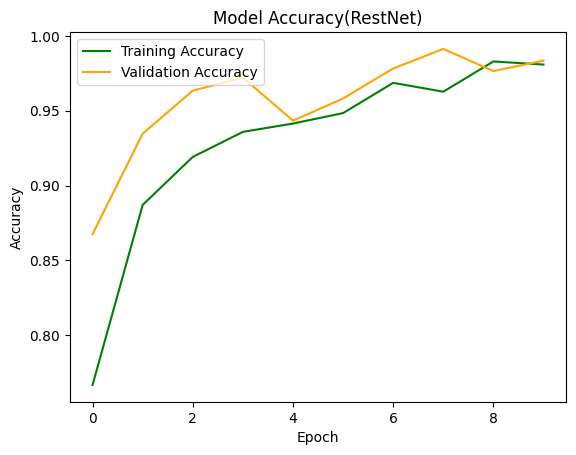

In [ ]:
plt.plot(history_vgg16.history["accuracy"], color="green", label="Training Accuracy")
plt.plot(history_vgg16.history["val_accuracy"], color="orange", label="Validation Accuracy")
plt.title("Model Accuracy(RestNet)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

# Data Prediction in VGG16 Model

In [ ]:
image_to_test1 = cv2.imread("/content/Test_output/glioma_tumor/image(76).jpg")
image_to_test1 = cv2.resize(image_to_test1, (128, 128))
image_to_test1 = image_to_test1.reshape(1, 128, 128, 3)

image_to_test2 = cv2.imread("/content/Test_output/pituitary_tumor/image(88).jpg")
image_to_test2 = cv2.resize(image_to_test2, (128, 128))
image_to_test2 = image_to_test2.reshape(1, 128, 128, 3)

categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
pred1 = np.argmax(model_vgg16.predict(image_to_test1))
pred2 = np.argmax(model_vgg16.predict(image_to_test2))

print("Prediction 1: \nActual data : glioma_tumor \nPredicted data :", categories[pred1])
if categories[pred1] == "glioma_tumor":
    print("Correct prediction!\n\n")

print("Prediction 2: \nActual data : pituitary_tumor \nPredicted data :", categories[pred2])
if categories[pred2] == "pituitary_tumor":
    print("Correct prediction!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Prediction 1: 
Actual data : glioma_tumor 
Predicted data : glioma_tumor
Correct prediction!


Prediction 2: 
Actual data : pituitary_tumor 
Predicted data : pituitary_tumor
Correct prediction!
